# <b>Contents:</b>
* Importing and reading data

### <b>Importing and reading data:</b>

In [1]:
! pip install -Uqq timm

In [2]:
!pip install fastai

In [3]:
import albumentations as A
import timm
from pathlib import Path
from fastai.vision.all import *
from fastai.vision.all import vision_learner, get_image_files

In [4]:
path = Path("/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset")
path.ls()

(#4) [Path('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords'),Path('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Valid'),Path('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Test'),Path('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Train')]

#### <b>Looking at the data</b>

In [5]:
trn_path = path/'Train'
files = get_image_files(trn_path)

(271, 186)


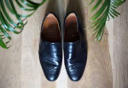

In [6]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Most of the images in the dataset can be of (271,186) , anyways we can take a look at them

In [7]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(225, 225)    2315
(183, 275)    1008
(194, 259)     994
(275, 183)     391
(199, 254)     311
              ... 
(375, 135)       1
(464, 108)       1
(350, 144)       1
(250, 155)       1
(176, 286)       1
Length: 477, dtype: int64

- Seems like the dataset consists of images of multiples sizes 
- We need to make sure the images in the dataset are of common sizes to ensure that there is no data leakage

### <b>Data Pre-processing:</b>

- In the previous notebook we squished the images , however in this notebook we can try to rezise the images and then perform data augmentation

In [11]:
trn_path = Path('/sml')

In [12]:
resize_images(path/'Train', dest=trn_path, max_size=224, recurse=True)

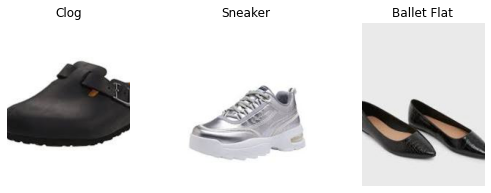

In [13]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((224,168)))

dls.show_batch(max_n=3)

In [14]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

### <b>Resnet26d:</b>

In [15]:
learn = train('resnet26d', item=Resize(168),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.192118,0.845061,0.297500,00:52


epoch,train_loss,valid_loss,error_rate,time
0,0.808622,0.623168,0.219000,00:46
1,0.661110,0.552864,0.195000,00:47
2,0.518914,0.483249,0.164500,00:46
3,0.373415,0.441594,0.147000,00:47
4,0.289079,0.443677,0.149000,00:46


- This is giving us quite an improved performance over the previous one.

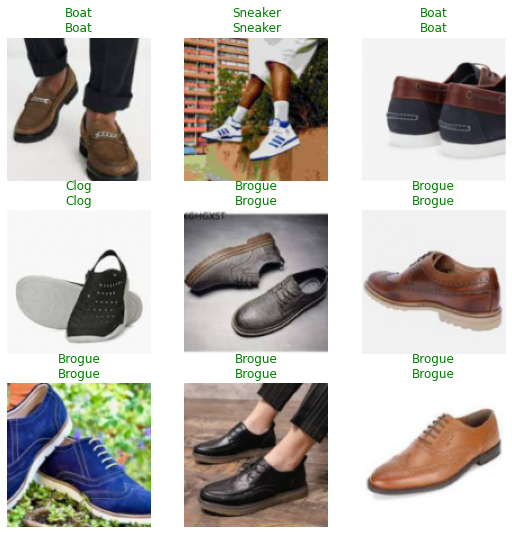

In [16]:
learn.show_results()

### <b>ConvNeXt:</b>

In [17]:
arch = 'convnext_small_in22k'

In [18]:
learn = train(arch, item=Resize(168, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.800847,0.593104,0.180500,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.485104,0.423241,0.139500,01:00
1,0.395023,0.345039,0.106500,00:59
2,0.283208,0.321791,0.094000,00:58
3,0.184180,0.309423,0.084500,00:59
4,0.117525,0.299878,0.081000,00:59


- This seems to be a better model and gives us much better accuracy compared to Resnet26d

### <b>Pre-processing:</b>

- We squished the images previously now let us try to crop

In [19]:
learn = train(arch, item=Resize(168),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,0.814545,0.586722,0.170500,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.506598,0.379146,0.110500,00:57
1,0.431924,0.366093,0.112000,00:59
2,0.310402,0.328435,0.098500,00:58
3,0.216287,0.296366,0.088000,00:58
4,0.164977,0.301876,0.091000,00:58


- Cropping the images doesnt seem to have an effect.
- Let us add padding which doesnt affect the images.

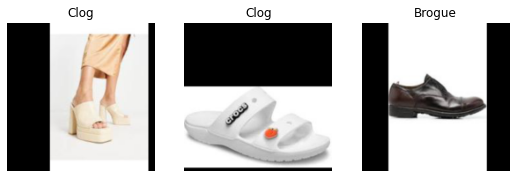

In [20]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(168, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [21]:
learn = train(arch, item=Resize((225,168), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(150,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,0.819714,0.548698,0.172500,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.501499,0.433953,0.142000,00:58
1,0.423908,0.334311,0.102000,01:00
2,0.317273,0.308552,0.091500,01:00
3,0.207685,0.291883,0.078500,01:00
4,0.160559,0.289768,0.076000,01:00


- Padding the images has given the model quite an improvment over the previous attempts.

### Test Time augmentation:

- Checking the error rate of the model without TTA

In [22]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [23]:
error_rate(preds, targs)

TensorBase(0.0760)

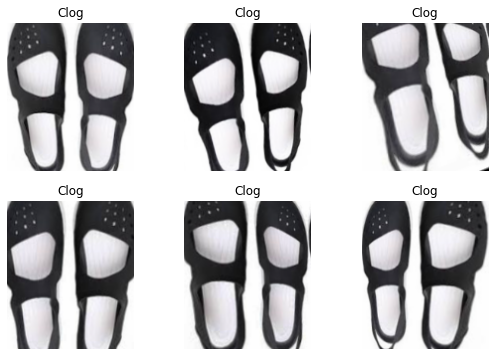

In [24]:
learn.dls.train.show_batch(max_n=6, unique=True)

In [25]:
tta_preds,_ = learn.tta(dl=valid)

In [26]:
error_rate(tta_preds, targs)

TensorBase(0.0800)

### **Scaling the Model:**

- Training the model over a larger image sizes and more epochs!

In [27]:
trn_path = path/'Train'

In [28]:
learn = train(arch, epochs=12,
              item=Resize((225,225), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(225,168), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,0.668751,0.519125,0.139500,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.383699,0.347674,0.102500,01:22
1,0.300823,0.354549,0.096500,01:22
2,0.300048,0.358759,0.093000,01:22
3,0.224602,0.344752,0.085500,01:21
4,0.167807,0.346401,0.084500,01:22
5,0.127391,0.373498,0.075000,01:21
6,0.086937,0.396894,0.070000,01:23
7,0.062639,0.391694,0.071000,01:22
8,0.040904,0.417259,0.074500,01:22
9,0.023459,0.425477,0.071500,01:21


### Interpreting the results:

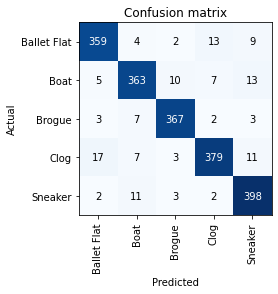

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

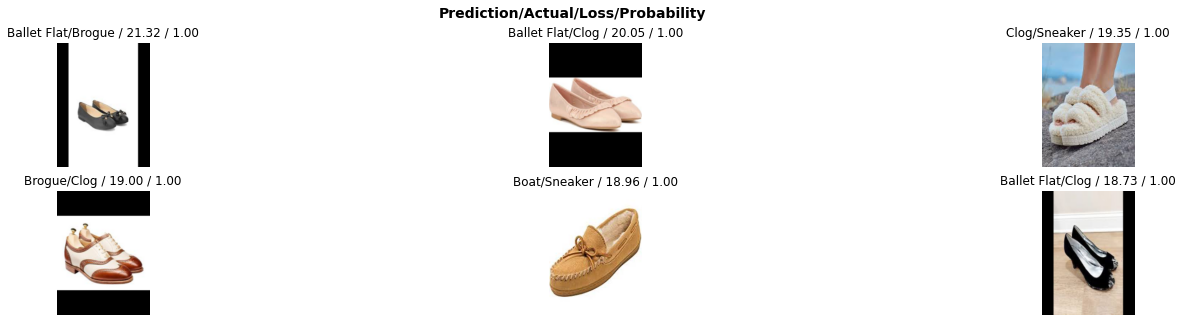

In [32]:
interp.plot_top_losses(6,figsize = (25,5))

### **Prediction using trained model**

- Let us randomly give a image to see how our model predicts

In [36]:
learn.predict('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Test/Boat/Boat Shoe-Test (102).jpeg')

('Boat',
 TensorBase(1),
 TensorBase([4.9393e-04, 6.6237e-01, 7.9263e-02, 2.5787e-01, 6.3527e-06]))

### <b> Saving and Load the model:<b>

In [39]:
learn.export(Path("/kaggle/working/export.pkl"))
learn.model_dir = "/kaggle/working"
learn.save("stage-2")

Path('/kaggle/working/stage-2.pth')